In [ ]:
!pip install tensorflow numpy scikit-learn


In [ ]:
pip install tqdm


In [2]:
import pandas as pd
from typing import Optional
import numpy as np
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [ ]:

def merge_demographic_timeseries(
    demographic_df: pd.DataFrame,
    timeseries_df: pd.DataFrame,
    subject_id_col: str = 'Subject_ID',
    time_col: str = 'Elapsed Time (sec)'
) -> pd.DataFrame:

      # Validate inputs
    for df, name in [(demographic_df, 'demographic_df'),
                     (timeseries_df, 'timeseries_df')]:
        if subject_id_col not in df.columns:
            raise ValueError(f"{subject_id_col} column missing in {name}")

    if time_col not in timeseries_df.columns:
        raise ValueError(f"Time column '{time_col}' not found in time series data")

    # First, sort time series by subject and time to ensure temporal order
    timeseries_df = timeseries_df.sort_values([subject_id_col, time_col])

    # Get unique subjects and shuffle them
    unique_subjects = timeseries_df[subject_id_col].unique()
    shuffled_subjects = np.random.permutation(unique_subjects)

    # Create empty list to store DataFrames for each subject
    subject_dfs = []

    # Process each subject's data in shuffled order
    for subject in shuffled_subjects:
        # Get this subject's time series data (already sorted by time)
        subject_data = timeseries_df[timeseries_df[subject_id_col] == subject]

        # Merge with demographic data for this subject
        subject_demographics = demographic_df[demographic_df[subject_id_col] == subject]

        if len(subject_demographics) == 0:
            raise ValueError(f"No demographic data found for subject {subject}")

        # Merge time series and demographics for this subject
        subject_merged = pd.merge(
            subject_data,
            subject_demographics,
            on=subject_id_col,
            how='left'
        )

        subject_dfs.append(subject_merged)

    # Concatenate all subjects' data in shuffled order
    merged_df = pd.concat(subject_dfs, axis=0, ignore_index=True)

    # Reorder columns (time series features first, then demographic)
    common_cols = list(set(timeseries_df.columns) & set(demographic_df.columns))
    timeseries_cols = [col for col in timeseries_df.columns
                      if col not in demographic_df.columns]
    demographic_cols = [col for col in demographic_df.columns
                       if col not in timeseries_df.columns]

    final_column_order = common_cols + timeseries_cols + demographic_cols
    merged_df = merged_df[final_column_order]

    return merged_df


In [ ]:
TS_Data = pd.read_csv('shuffled_Ts_data.csv')
demographic_data = pd.read_csv('shuffled_data.csv')

# Merge the datasets
combined_df = merge_demographic_timeseries(
        demographic_df=demographic_data,
        timeseries_df=TS_Data,
        subject_id_col='Subject_ID',
        time_col='Elapsed Time (sec)'
    )


In [3]:
combined_df.to_csv('merged_dataset.csv', index=False)
print("\nMerged dataset saved to 'merged_dataset.csv'")

NameError: name 'combined_df' is not defined

In [4]:
combined_df= pd.read_csv('merged_dataset.csv')

In [5]:
subject_row_counts = combined_df.groupby("Subject_ID").size().reset_index(name="Row_Count")


# Display the result
print(subject_row_counts)

   Subject_ID  Row_Count
0        als1        194
1       als10        246
2       als11        229
3       als12        122
4       als13        183
..        ...        ...
59      park5        263
60      park6        269
61      park7        226
62      park8        203
63      park9        222

[64 rows x 2 columns]


In [6]:
combined_df['ALS_Severity'] = combined_df['Disorder_ALS'] * combined_df['Duration/Severity']
combined_df['Huntington_Severity'] = combined_df['Disorder_hunt'] * combined_df['Duration/Severity']
combined_df['Parkinson_Severity'] = combined_df['Disorder_park'] * combined_df['Duration/Severity']


In [7]:
combined_df.head()


,Subject_ID,Elapsed Time (sec),Left Stride Interval (sec),Right Stride Interval (sec),Left Swing Interval (sec),Right Swing Interval (sec),Left Swing Interval (% of stride),Right Swing Interval (% of stride),Left Stance Interval (sec),Right Stance Interval (sec),...,GaitSpeed(m/sec),Duration/Severity,Normalized_Severity,Disorder_ALS,Disorder_Normal,Disorder_hunt,Disorder_park,ALS_Severity,Huntington_Severity,Parkinson_Severity
0,control2,0.000898,0.011898,0.011748,0.016504,0.013206,0.423098,0.426489,0.006849,0.006758,...,0.734848,0.0,0.0,0,1,0,0,0.0,0.0,0.0
1,control2,0.005075,0.011776,0.011114,0.016504,0.012728,0.425499,0.427490,0.006726,0.006351,...,0.734848,0.0,0.0,0,1,0,0,0.0,0.0,0.0
2,control2,0.009348,0.012264,0.011805,0.016366,0.013324,0.412837,0.428381,0.007277,0.006758,...,0.734848,0.0,0.0,0,1,0,0,0.0,0.0,0.0
3,control2,0.013669,0.012508,0.011690,0.016924,0.013206,0.420260,0.427713,0.007277,0.006700,...,0.734848,0.0,0.0,0,1,0,0,0.0,0.0,0.0
4,control2,0.017835,0.011715,0.011633,0.016504,0.012493,0.426809,0.410017,0.006666,0.006990,...,0.734848,0.0,0.0,0,1,0,0,0.0,0.0,0.0


In [8]:
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val) if max_val > min_val else 0

In [9]:
ALS_MAX =  combined_df['ALS_Severity'].max()# Upper bound for ALS in months
HUNTINGTONS_MAX = 13  # Total Functional Capacity scale
PARKINSONS_MAX = 5  # Hohn and Yahr scale

# Normalize each severity column separately
combined_df['ALS_Severity'] = combined_df['ALS_Severity'].apply(lambda x: normalize(x, 0, ALS_MAX))
combined_df['Huntington_Severity'] = combined_df['Huntington_Severity'].apply(lambda x: normalize(x, 0, HUNTINGTONS_MAX))
combined_df['Parkinson_Severity'] = combined_df['Parkinson_Severity'].apply(lambda x: normalize(x, 0, PARKINSONS_MAX))

In [10]:
combined_df.drop(columns=['Duration/Severity','Normalized_Severity'], inplace=True)
combined_df.head()

,Subject_ID,Elapsed Time (sec),Left Stride Interval (sec),Right Stride Interval (sec),Left Swing Interval (sec),Right Swing Interval (sec),Left Swing Interval (% of stride),Right Swing Interval (% of stride),Left Stance Interval (sec),Right Stance Interval (sec),...,Weight(kg),gender,GaitSpeed(m/sec),Disorder_ALS,Disorder_Normal,Disorder_hunt,Disorder_park,ALS_Severity,Huntington_Severity,Parkinson_Severity
0,control2,0.000898,0.011898,0.011748,0.016504,0.013206,0.423098,0.426489,0.006849,0.006758,...,0.380543,1,0.734848,0,1,0,0,0.0,0.0,0.0
1,control2,0.005075,0.011776,0.011114,0.016504,0.012728,0.425499,0.427490,0.006726,0.006351,...,0.380543,1,0.734848,0,1,0,0,0.0,0.0,0.0
2,control2,0.009348,0.012264,0.011805,0.016366,0.013324,0.412837,0.428381,0.007277,0.006758,...,0.380543,1,0.734848,0,1,0,0,0.0,0.0,0.0
3,control2,0.013669,0.012508,0.011690,0.016924,0.013206,0.420260,0.427713,0.007277,0.006700,...,0.380543,1,0.734848,0,1,0,0,0.0,0.0,0.0
4,control2,0.017835,0.011715,0.011633,0.016504,0.012493,0.426809,0.410017,0.006666,0.006990,...,0.380543,1,0.734848,0,1,0,0,0.0,0.0,0.0


In [11]:

import random
hunt_subjects = combined_df[combined_df["Disorder_hunt"] == 1]["Subject_ID"].unique()

# Step 2: Randomly select 5 subjects to remove
subjects_to_remove = random.sample(list(hunt_subjects), min(5, len(hunt_subjects)))  # Handle cases with <5 subjects

# Step 3: Filter out rows belonging to the selected subjects
filtered_data = combined_df[~combined_df["Subject_ID"].isin(subjects_to_remove)]

# Print the results
print(f"Dropped subjects: {subjects_to_remove}")
print("Filtered data:")
print(filtered_data)

Dropped subjects: ['hunt19', 'hunt7', 'hunt15', 'hunt14', 'hunt5']
Filtered data:
      Subject_ID  Elapsed Time (sec)  Left Stride Interval (sec)  \
0       control2            0.000898                    0.011898   
1       control2            0.005075                    0.011776   
2       control2            0.009348                    0.012264   
3       control2            0.013669                    0.012508   
4       control2            0.017835                    0.011715   
...          ...                 ...                         ...   
15155  control10            0.980322                    0.008969   
15156  control10            0.984272                    0.010617   
15157  control10            0.988054                    0.009762   
15158  control10            0.991860                    0.009885   
15159  control10            0.995523                    0.009152   

       Right Stride Interval (sec)  Left Swing Interval (sec)  \
0                         0.011748  

In [12]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Group by Subject_ID and assign the primary disorder for each subject
subject_disorders = filtered_data.groupby('Subject_ID')[['Disorder_ALS', 'Disorder_Normal',
                                                       'Disorder_hunt', 'Disorder_park']].first()
subject_classes = subject_disorders.idxmax(axis=1)  # Assign the primary disorder as the "class"

# Stratified subject-level split
train_subjects, test_subjects = train_test_split(
    subject_disorders.index,  # Unique subjects
    test_size=0.2,
    stratify=subject_classes.values,  # Stratify by disorder class
    random_state=42
)

# Create masks for train/test data based on Subject_ID
train_mask = filtered_data['Subject_ID'].isin(train_subjects)
test_mask = filtered_data['Subject_ID'].isin(test_subjects)

# Split the combined data
train_data = filtered_data[train_mask]
test_data = filtered_data[test_mask]

# Verify stratification
train_class_distribution = train_data.groupby('Subject_ID')[['Disorder_ALS', 'Disorder_Normal',
                                                              'Disorder_hunt', 'Disorder_park']].first().idxmax(axis=1).value_counts()
test_class_distribution = test_data.groupby('Subject_ID')[['Disorder_ALS', 'Disorder_Normal',
                                                            'Disorder_hunt', 'Disorder_park']].first().idxmax(axis=1).value_counts()




In [13]:
# Output
print(f"Train subjects: {len(train_subjects)}")
print(f"Train shape: {train_data.shape}")
print("Train class distribution:")
print(train_class_distribution)

print(f"Test subjects: {len(test_subjects)}")
print(f"Test shape: {test_data.shape}")
print("Test class distribution:")
print(test_class_distribution)

Train subjects: 47
Train shape: (11266, 26)
Train class distribution:
Disorder_Normal    13
Disorder_hunt      12
Disorder_park      12
Disorder_ALS       10
Name: count, dtype: int64
Test subjects: 12
Test shape: (2684, 26)
Test class distribution:
Disorder_ALS       3
Disorder_Normal    3
Disorder_hunt      3
Disorder_park      3
Name: count, dtype: int64


In [14]:
print(train_data.head())

  Subject_ID  Elapsed Time (sec)  Left Stride Interval (sec)  \
0   control2            0.000898                    0.011898   
1   control2            0.005075                    0.011776   
2   control2            0.009348                    0.012264   
3   control2            0.013669                    0.012508   
4   control2            0.017835                    0.011715   

   Right Stride Interval (sec)  Left Swing Interval (sec)  \
0                     0.011748                   0.016504   
1                     0.011114                   0.016504   
2                     0.011805                   0.016366   
3                     0.011690                   0.016924   
4                     0.011633                   0.016504   

   Right Swing Interval (sec)  Left Swing Interval (% of stride)  \
0                    0.013206                           0.423098   
1                    0.012728                           0.425499   
2                    0.013324               

# pad the sequences


In [15]:
# Function to pad combined data (features + labels)
def pad_combined_data(data, max_length):
    subject_ids = data['Subject_ID'].values
    combined_values = data.iloc[:, 1:].values.astype(float)

    padded_data = []
    for subject in pd.unique(subject_ids):  # pd.unique preserves order
        subject_data = combined_values[subject_ids == subject]

        # Pad to the maximum sequence length
        padded_subject_data = pad_sequences(
            [subject_data], maxlen=max_length, padding='post', dtype='float32'
        )[0]
        padded_data.append(padded_subject_data)

    return np.concatenate(padded_data, axis=0)

# Calculate max sequence lengths for train/test sets
max_train_length = train_data.groupby('Subject_ID').size().max()
max_test_length = test_data.groupby('Subject_ID').size().max()

# Pad train and test data
train_padded = pad_combined_data(train_data, max_train_length)
test_padded = pad_combined_data(test_data, max_test_length)


In [175]:
print(train_padded)

[[0.00089773 0.01189822 0.01174845 ... 0.         0.         0.        ]
 [0.00507505 0.01177558 0.01111437 ... 0.         0.         0.        ]
 [0.00934825 0.01226432 0.01180546 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]


In [16]:
print(train_padded.shape)
print(test_padded.shape)

(14570, 25)
(3300, 25)


In [17]:
# Extract Features (columns 1 to 18, zero-indexed as 0 to 17)
X_train_padded = train_padded[:, :18]
# Extract Target Class (columns 19 to 22, zero-indexed as 18 to 21)
y_class_train_padded= train_padded[:, 18:22]
# Extract Target Regression (columns 23 to 25, zero-indexed as 22 to 24)
y_reg_train_padded = train_padded[:, 22:25]

X_test_padded = test_padded[:, :18]
# Extract Target Class (columns 19 to 22, zero-indexed as 18 to 21)
y_class_test_padded = test_padded[:, 18:22]
# Extract Target Regression (columns 23 to 25, zero-indexed as 22 to 24)
y_reg_test_padded = test_padded[:, 22:25]



In [18]:
print(f"X_train shape (features): {X_train_padded.shape}")
print(f"y_class_train shape (target class): {y_class_train_padded.shape}")
print(f"y_reg_train shape (target regression): {y_reg_train_padded.shape}")

print(f"X_test shape (features): {X_test_padded.shape}")
print(f"y_class_test shape (target class): {y_class_test_padded.shape}")
print(f"y_reg_test shape (target regression): {y_reg_test_padded.shape}")


X_train shape (features): (14570, 18)
y_class_train shape (target class): (14570, 4)
y_reg_train shape (target regression): (14570, 3)
X_test shape (features): (3300, 18)
y_class_test shape (target class): (3300, 4)
y_reg_test shape (target regression): (3300, 3)


In [19]:
print(y_class_train_padded)

[[0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 ...
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [20]:
n_test_subjects=len(test_subjects)
n_train_subjects=len(train_subjects)

In [21]:
n_classes = y_class_train_padded.shape[1]
print("number of classes:",n_classes)
n_features = X_train_padded.shape[1]
print("number of features:",n_features)
print("number of training subjects:",n_train_subjects)
print("number of testing subjects:",n_test_subjects)
print("max train length:",max_train_length)
print("max test length:",max_test_length)
gru_units = 64
dense_units = [128, 64]

number of classes: 4
number of features: 18
number of training subjects: 47
number of testing subjects: 12
max train length: 310
max test length: 275


In [22]:
import numpy as np
import numpy as np

def convert_to_3d(padded_data,  max_length, num_features, num_subjects, ):

    reshaped_data = np.zeros((num_subjects, max_length, num_features), dtype=np.float32)

    # Ensure data is already ordered per subject in `padded_data`
    rows_per_subject = len(padded_data) // num_subjects  # Average rows per subject
    if rows_per_subject * num_subjects != len(padded_data):
        raise ValueError("Padded data length must be divisible by the number of subjects.")

    for i in range(num_subjects):
        start_idx = i * rows_per_subject
        end_idx = start_idx + rows_per_subject
        subject_data = padded_data[start_idx:end_idx]

        reshaped_data[i, :len(subject_data), :] = subject_data[:max_length]

    return reshaped_data



# Example Usage (Assuming you already have num_subjects, max_train_length, max_test_length, and n_features)
X_train_3d = convert_to_3d(X_train_padded, max_train_length, n_features, n_train_subjects)
X_test_3d = convert_to_3d(X_test_padded, max_test_length, n_features, n_test_subjects)
y_class_train_3d = convert_to_3d(y_class_train_padded, max_train_length, n_classes, n_train_subjects)
y_reg_train_3d = convert_to_3d(y_reg_train_padded, max_train_length, 3, n_train_subjects)
y_class_test_3d = convert_to_3d(y_class_test_padded, max_test_length, n_classes, n_test_subjects)
y_reg_test_3d = convert_to_3d(y_reg_test_padded, max_test_length, 3, n_test_subjects)
# Output the shapes
print("3D X_train shape:", X_train_3d.shape)  # (num_subjects, max_length, num_features)
print("3D X_test shape:", X_test_3d.shape)
print("3D y_class_train shape:", y_class_train_3d.shape)
print("3D y_reg_train shape:", y_reg_train_3d.shape)
print("3D y_class_test shape:", y_class_test_3d.shape)
print("3D y_reg_test shape:", y_reg_test_3d.shape)


3D X_train shape: (47, 310, 18)
3D X_test shape: (12, 275, 18)
3D y_class_train shape: (47, 310, 4)
3D y_reg_train shape: (47, 310, 3)
3D y_class_test shape: (12, 275, 4)
3D y_reg_test shape: (12, 275, 3)


In [23]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GRU, Dense, TimeDistributed, Lambda
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import tensorflow as tf
tf.config.run_functions_eagerly(True)
import tensorflow as tf
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.losses import MeanSquaredError as mse
from tensorflow.keras.metrics import Accuracy
from tensorflow.keras.layers import BatchNormalization, Dropout

In [39]:
# Define the model (without regression output)
def build_model(input_shape, num_classes):
    # Input layer
    inputs = Input(shape=input_shape, name="Input_Layer")

    # GRU hidden layers
    x = GRU(64, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, name="GRU_Layer_1")(inputs)
    x = BatchNormalization()(x)  # Add batch normalization after GRU
    x = GRU(32, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, name="GRU_Layer_2")(x)
    x = GRU(32, return_sequences=True, dropout=0.0, recurrent_dropout=0.0, name="GRU_Layer_3")(x)
    x = Dropout(0.2)(x)

    # Classification output
    classification_output = TimeDistributed(
        Dense(num_classes, activation="softmax"), name="Classification_Output"
    )(x)

    # Build the model
    model = Model(inputs=inputs, outputs=[classification_output])
    return model



In [40]:
input_shape = (None, 18)  # Max train sequence length and number of features
num_classes = 4  # Classification output classes


model = build_model(input_shape, num_classes)

In [41]:
model.summary()

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ Input_Layer (InputLayer)             │ (None, None, 18)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Layer_1 (GRU)                    │ (None, None, 64)            │          16,128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, None, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Layer_2 (GRU)                    │ (None, None, 32)            │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ GRU_Layer_3 (GRU)                    │ (None, None, 32)            │           6,336 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, None, 32)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Classification_Output                │ (None, None, 4)             │             132 │
│ (TimeDistributed)                    │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 32,260 (126.02 KB)

 Trainable params: 32,132 (125.52 KB)

 Non-trainable params: 128 (512.00 B)

In [42]:

# Compile with only classification loss
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss={'Classification_Output': 'categorical_crossentropy'},
    metrics={
        "Classification_Output": ["accuracy"]
    }
)

In [47]:
from sklearn.model_selection import KFold
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define data properties
num_subjects = X_train_3d.shape[0]  # Subjects are in the first dimension
k_folds = 5  # Number of folds

# K-Fold Cross-Validation setup
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
fold_metrics = []  # Store results for each fold

# Cross-validation loop
for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(num_subjects))):
    print(f"\n--- Fold {fold + 1}/{k_folds} ---")

    # Split the dataset by subjects
    X_fold_train, X_fold_val = X_train_3d[train_idx], X_train_3d[val_idx]
    y_fold_train, y_fold_val = y_class_train_3d[train_idx], y_class_train_3d[val_idx]

    # Define the model for this fold
    model = build_model(input_shape, num_classes)

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.01),
        loss={"Classification_Output": "categorical_crossentropy"},
        metrics={"Classification_Output": ["accuracy"]},
    )

    # Callbacks for training
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=5, restore_best_weights=True
    )
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
      filepath=f"model_fold_{fold + 1}.keras",  # Update to .keras
      save_best_only=True,
      monitor="val_loss",
      verbose=1
  )

    lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3)

    # Train the model
    history = model.fit(
        X_fold_train, y_fold_train,
        validation_data=(X_fold_val, y_fold_val),
        epochs=20,
        batch_size=32,
        callbacks=[early_stopping, model_checkpoint,lr_scheduler],
        verbose=1,
    )

    # Record validation metrics for this fold
    fold_metrics.append({
        "fold": fold + 1,
        "val_loss": min(history.history["val_loss"]),
        "val_accuracy": max(history.history["val_accuracy"]),
    })

# Summarize Cross-Validation Results
avg_val_loss = np.mean([m["val_loss"] for m in fold_metrics])
avg_val_accuracy = np.mean([m["val_accuracy"] for m in fold_metrics])

print(f"\n--- Cross-Validation Summary ---")
print(f"Average Validation Loss: {avg_val_loss:.4f}")
print(f"Average Validation Accuracy: {avg_val_accuracy:.4f}")



--- Fold 1/5 ---
Epoch 1/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.4681 - loss: 1.0327 
Epoch 1: val_loss improved from inf to 0.96795, saving model to model_fold_1.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 20s/step - accuracy: 0.4705 - loss: 1.0319 - val_accuracy: 0.2513 - val_loss: 0.9679 - learning_rate: 0.0100
Epoch 2/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.3385 - loss: 1.1573  
Epoch 2: val_loss improved from 0.96795 to 0.95420, saving model to model_fold_1.keras
2/2 ━━━━━━━━━━━━━━━━━━━━ 30s 20s/step - accuracy: 0.3430 - loss: 1.1561 - val_accuracy: 0.2419 - val_loss: 0.9542 - learning_rate: 0.0100
Epoch 3/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.5344 - loss: 0.7490 
Epoch 3: val_loss did not improve from 0.95420
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 15s/step - accuracy: 0.5357 - loss: 0.7564 - val_accuracy: 0.2190 - val_loss: 0.9988 - learning_rate: 0.0100
Epoch 4/20
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - accuracy: 0.6575 - loss: 0.7906 
Epoch 4: val_loss d

Fold 1: Train Accuracy = 0.4769, Test Accuracy = 0.4776
Fold 2: Train Accuracy = 0.5122, Test Accuracy = 0.3945
Fold 3: Train Accuracy = 0.3395, Test Accuracy = 0.3003
Fold 4: Train Accuracy = 0.4130, Test Accuracy = 0.2300
Fold 5: Train Accuracy = 0.3824, Test Accuracy = 0.3691


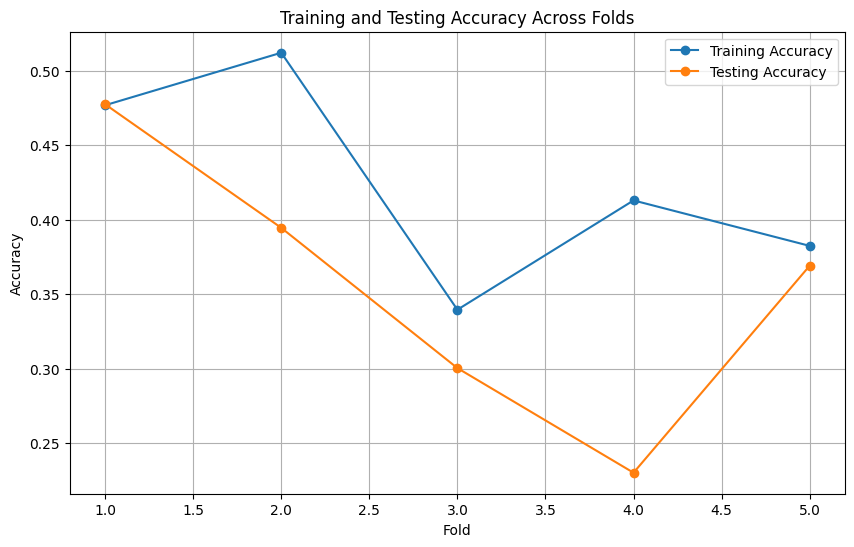

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Placeholder for metrics
fold_test_metrics = []
fold_training_accuracy = []

# Function to calculate accuracy manually
def calculate_accuracy(y_true, y_pred):
    # Convert predictions to class labels (if needed)
    y_pred_classes = np.argmax(y_pred, axis=-1)
    y_true_classes = np.argmax(y_true, axis=-1)
    # Calculate the proportion of correct predictions
    return np.mean(y_pred_classes == y_true_classes)

# Iterate through folds
for fold_number in range(1, 6):  # Fold numbers 1 to 5
    # Load the saved model for the fold
    model_path = f"model_fold_{fold_number}.keras"
    model = load_model(model_path)

    # Predict on the training set
    train_predictions = model.predict(X_train_3d, verbose=0)
    train_accuracy = calculate_accuracy(y_class_train_3d, train_predictions)
    fold_training_accuracy.append(train_accuracy)

    # Predict on the test set
    test_predictions = model.predict(X_test_3d, verbose=0)
    test_accuracy = calculate_accuracy(y_class_test_3d, test_predictions)

    # Store metrics
    fold_test_metrics.append({
        "fold": fold_number,
        "test_accuracy": test_accuracy,
    })

    # Print results for each fold
    print(f"Fold {fold_number}: Train Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Extracting data for plotting
test_accuracies = [metric["test_accuracy"] for metric in fold_test_metrics]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), fold_training_accuracy, label="Training Accuracy", marker='o')
plt.plot(range(1, 6), test_accuracies, label="Testing Accuracy", marker='o')
plt.title("Training and Testing Accuracy Across Folds")
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()


In [59]:
import numpy as np

# Calculate average and standard deviation
avg_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"\nAverage Test Accuracy: {avg_test_accuracy:.4f}")
print(f"Standard Deviation of Test Accuracy: {std_test_accuracy:.4f}")



Average Test Accuracy: 0.3543
Standard Deviation of Test Accuracy: 0.0841
